In [46]:
#!pip install wordcloud
#!pip install spacy
#!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 32.8 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import nltk
import spacy
import re
import pandas as pd
import numpy as np
import gensim
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
# loading the dataset
df = pd.read_excel('IMDB_dataset.xlsx')
df.head()

,review,sentiment
0,I thought this was a wonderful way to spend ti...,positive
1,"Probably my all-time favorite movie, a story o...",positive
2,I sure would like to see a resurrection of a u...,positive
3,"This show was an amazing, fresh & innovative i...",negative
4,Encouraged by the positive comments about this...,negative


### EDA and Preprocess

In [5]:
# shape of the dataframe
df.shape

(25000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [7]:
df.describe()

,review,sentiment
count,25000,25000
unique,24898,2
top,"When i got this movie free from my job, along ...",positive
freq,3,12500


In [8]:
num_duplicates = df.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 102 duplicate reviews present in the dataset


Looks like all values are not unique.

In [9]:
# removing duplicates
df.drop_duplicates(inplace = True, subset=None, keep='first')

In [10]:
df = df.reset_index(drop=True)
df.describe()

,review,sentiment
count,24898,24898
unique,24898,2
top,I thought this was a wonderful way to spend ti...,positive
freq,1,12470


We have sucessfully removed the duplicate values.

In [11]:
# checking for null values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

There is no null values in our dataset.

In [12]:
df['sentiment'].value_counts()

positive    12470
negative    12428
Name: sentiment, dtype: int64

So after removing duplicates we have 12470 positive and 12428 negative reviews

C:\Users\200535033\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


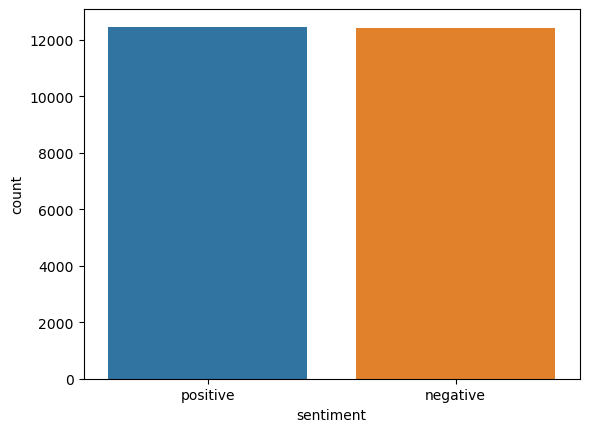

In [13]:
# visualising the counts of the labels
sns.countplot(df['sentiment'])
plt.show()

The data looks like a balanced dataset.

In [14]:
# loading stop words
stop_words = nlp.Defaults.stop_words
# removing 'not' word from stop words list because this word has enough effect on sentiment
nlp.Defaults.stop_words.remove('not')
nlp.vocab['not'].is_stop = False

In [15]:
# creating a function to preprocess all text
def preprocess(sentence):
    # making all words in lower case
    sentence = sentence.lower()
    # removing HTML tag
    sentence = sentence.replace('<br /><br />', ' ')
    # removing URL
    sentence = sentence.replace('https://', ' ')
    # removing all characters other than alphabets
    sentence = re.sub('[^a-zA-Z]',' ',sentence)

    sentence = " ".join(sentence.split())
    
    # remove stop words
    raw = []
    for word in sentence.split():
        if word in stop_words:
            pass
        else:
            raw.append(word)
    sentence = ' '.join(raw)
    # lemmatization
    sentence = ' '.join([i.lemma_ for i in nlp(sentence)])
    
    
    return sentence

In [16]:
# checking the function
preprocess(df['review'][0])

'think wonderful way spend time hot summer weekend sit air condition theater watch light hearted comedy plot simplistic dialogue witty character likable bread suspect serial killer disappoint realize not match point risk addiction think proof woody allen fully control style grow love d laugh woody s comedy year dare decade ve impress scarlet johanson manage tone sexy image jump right average spirited young woman not crown jewel career wittier devil wear prada interesting superman great comedy friend'

In [17]:
# preprocessing all the reviews
review = [preprocess(text) for text in tqdm(df['review'])]
df['review'] = review
df.head()

100%|████████████████████████████████████████████████████████████████████████████| 24898/24898 [05:14<00:00, 79.20it/s]


,review,sentiment
0,think wonderful way spend time hot summer week...,positive
1,probably time favorite movie story selflessnes...,positive
2,sure like resurrection date seahunt series tec...,positive
3,amazing fresh innovative idea s air year brill...,negative
4,encourage positive comment film look forward w...,negative


In [18]:
# getting a look at the 20 most commonly used words in the reviews
l = df['review'].count()
all_words = [df['review'][i] for i in range(l)]
all_words = (' '.join(all_words)).split()
most_freq = Counter(all_words).most_common(20)
most_common_20_words = [a for (a,b) in most_freq]
print("The 20 most commonly used words in the reviews are: \n",most_common_20_words)

The 20 most commonly used words in the reviews are: 
 ['s', 'movie', 'film', 't', 'not', 'like', 'good', 'time', 'character', 'watch', 'bad', 'story', 'see', 'think', 'scene', 'great', 'look', 'know', 'people', 'don']


In [19]:
# all words used for positive reviews
df_pos = df[df['sentiment']=='positive'].reset_index()
all_positive_words = [df_pos['review'][i] for i in range(12470)]
all_positive_words = ' '.join(all_positive_words)

# all words used for negative reviews
df_neg = df[df['sentiment']=='negative'].reset_index()
all_negative_words = [df_neg['review'][i] for i in range(12428)]
all_negative_words = ' '.join(all_negative_words)

**WordCloud for positive reviews**

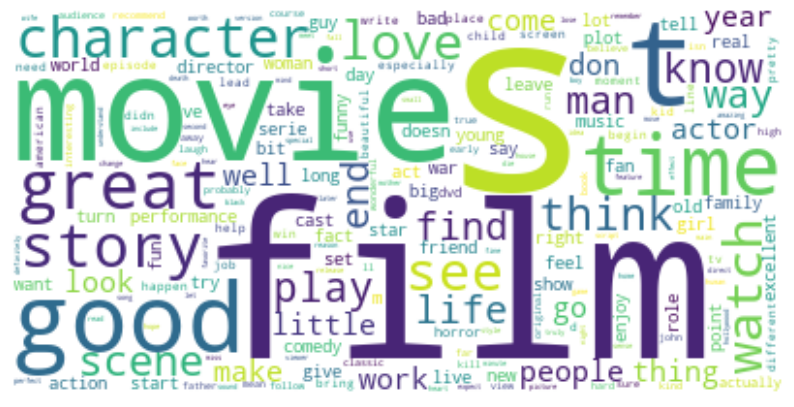

In [20]:
# Visualising the words used for positive reviews
plt.figure(figsize=(10,8))
word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(all_positive_words)
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

we have can see all the postive review words used visualised above

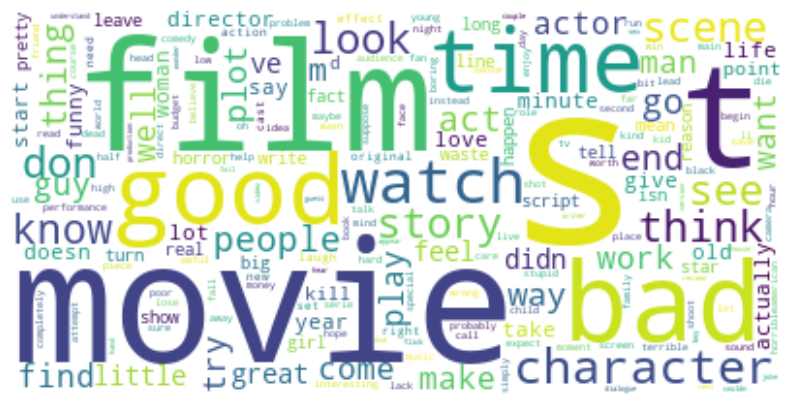

In [21]:
# Visualising the words used for negative reviews
plt.figure(figsize=(10,8))
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(all_negative_words)
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

we have can see all the negative review words used visualised above

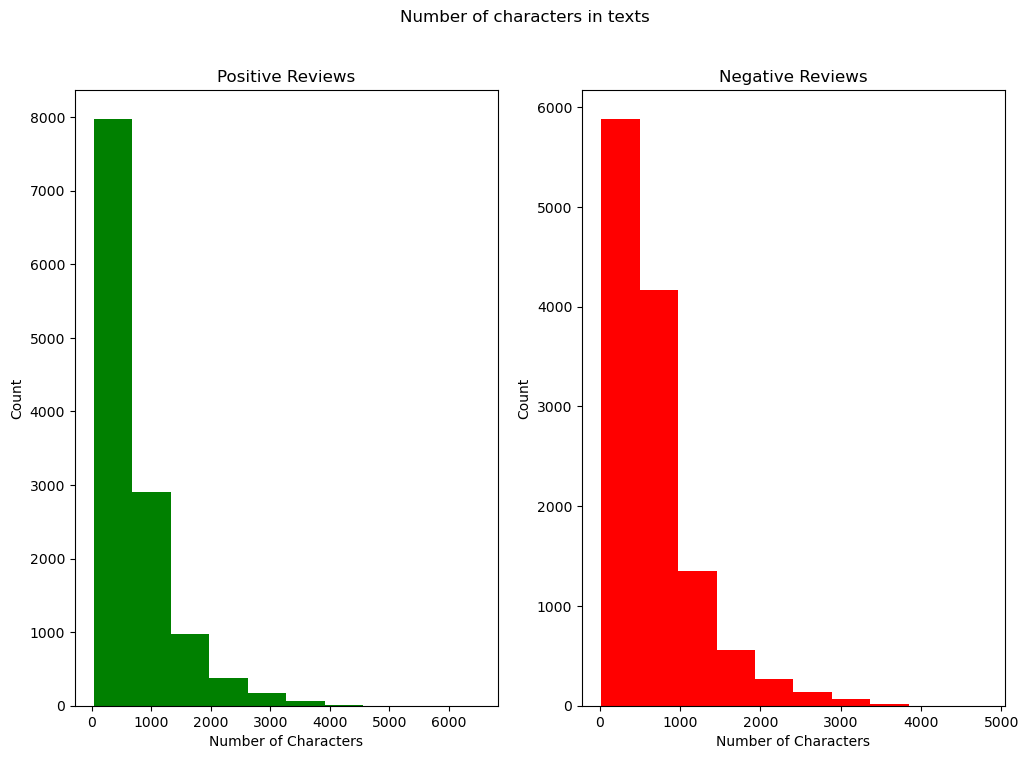

In [22]:
positive_data = df[df['sentiment'] == 'positive']['review']
negative_data = df[df['sentiment'] == 'negative']['review']
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()

we can see that the number characters used in postive reviews is higher than those used in negative reviews

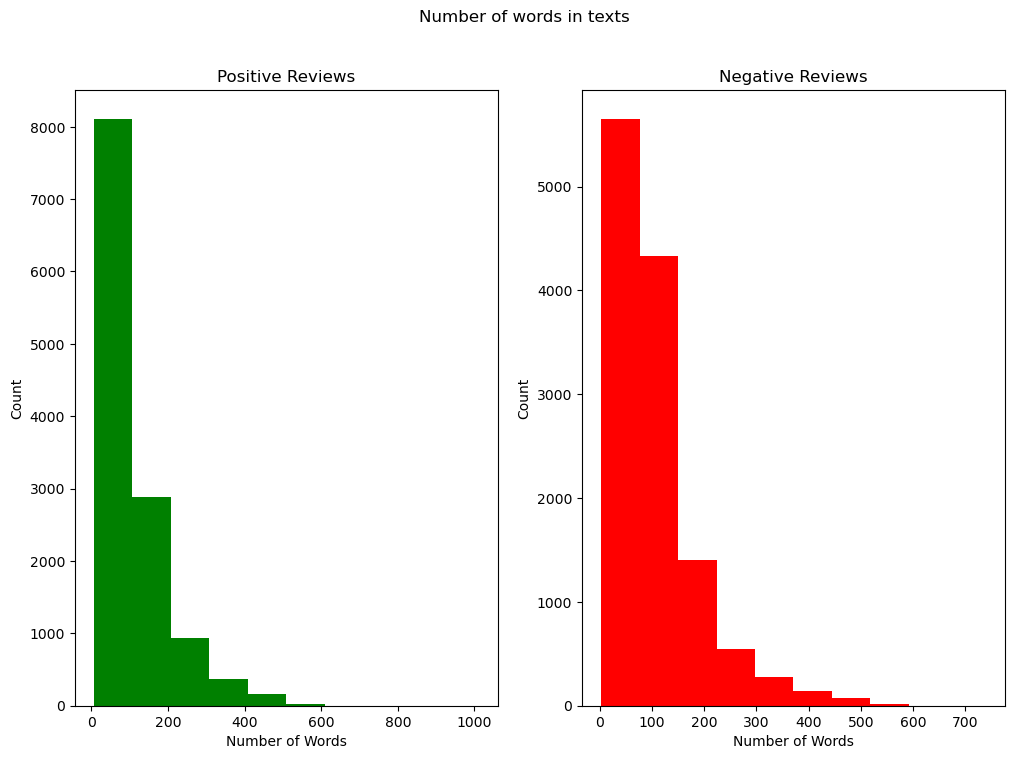

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

we can see that the number words used in postive reviews is higher than those used in negative reviews

- from this and the above graph for charachters we can infer that people tend leave longer worded postive reviews

C:\Users\200535033\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\200535033\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


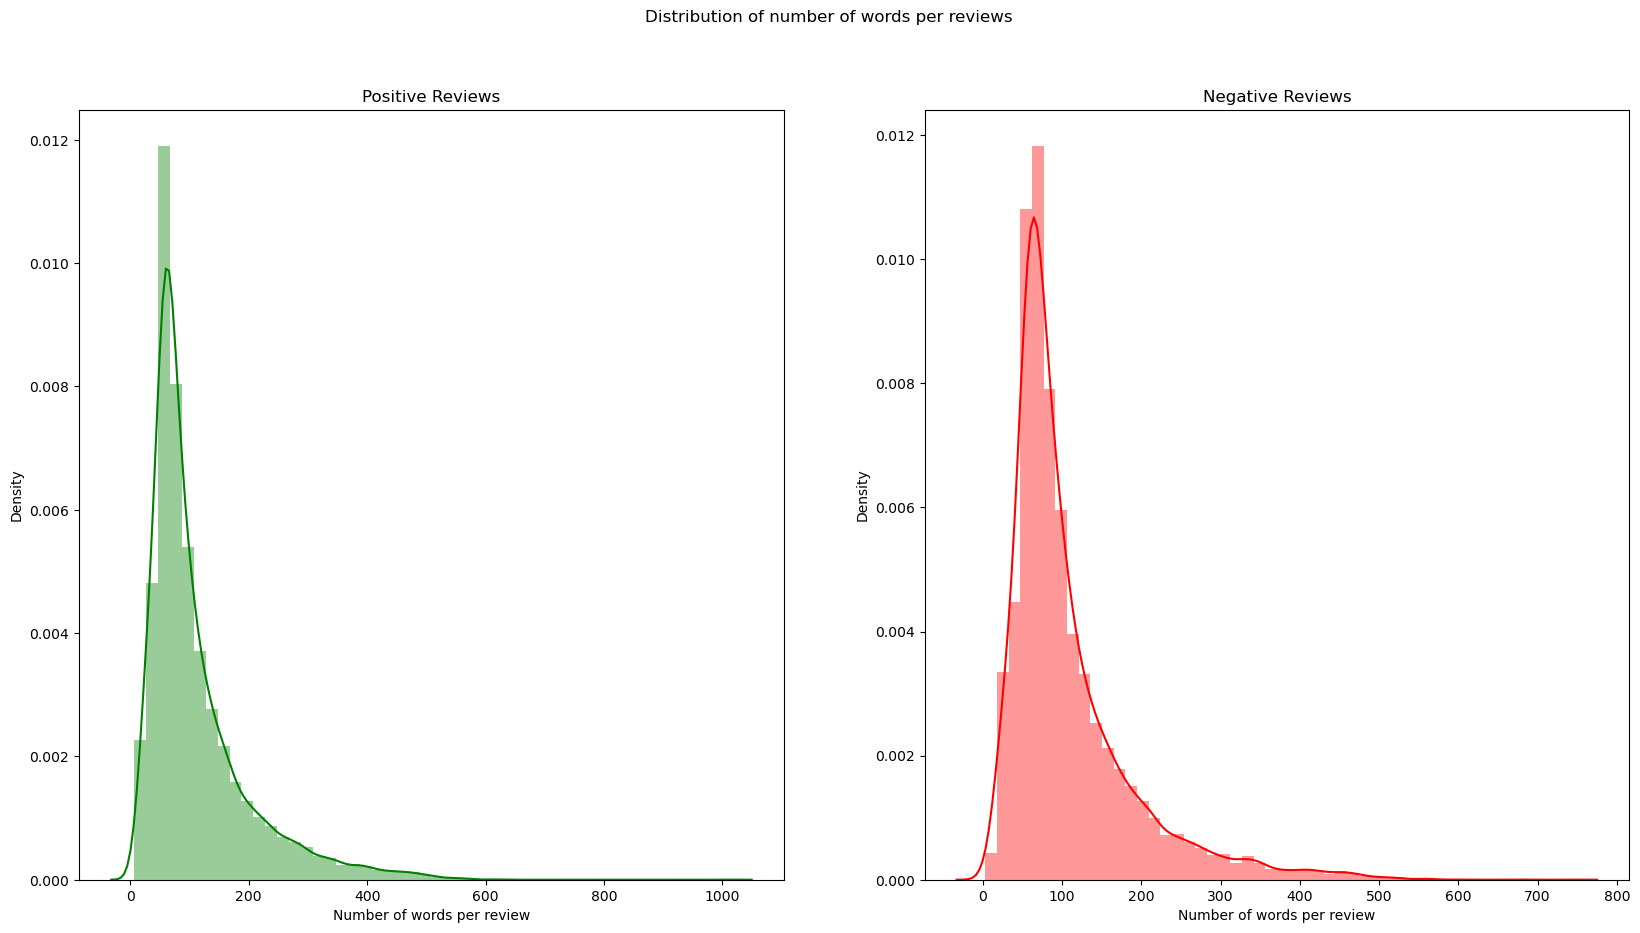

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.show()

In [25]:
# tokenizing the review texts and creating the corpus
corpus = []
for doc in tqdm(df['review']):
    words = [token.text for token in nlp(doc)]
    corpus.append(words)

100%|████████████████████████████████████████████████████████████████████████████| 24898/24898 [05:06<00:00, 81.35it/s]


In [26]:
# first three reviews from corpus 
corpus[:3]

[['think',
  'wonderful',
  'way',
  'spend',
  'time',
  'hot',
  'summer',
  'weekend',
  'sit',
  'air',
  'condition',
  'theater',
  'watch',
  'light',
  'hearted',
  'comedy',
  'plot',
  'simplistic',
  'dialogue',
  'witty',
  'character',
  'likable',
  'bread',
  'suspect',
  'serial',
  'killer',
  'disappoint',
  'realize',
  'not',
  'match',
  'point',
  'risk',
  'addiction',
  'think',
  'proof',
  'woody',
  'allen',
  'fully',
  'control',
  'style',
  'grow',
  'love',
  'd',
  'laugh',
  'woody',
  's',
  'comedy',
  'year',
  'dare',
  'decade',
  've',
  'impress',
  'scarlet',
  'johanson',
  'manage',
  'tone',
  'sexy',
  'image',
  'jump',
  'right',
  'average',
  'spirited',
  'young',
  'woman',
  'not',
  'crown',
  'jewel',
  'career',
  'wittier',
  'devil',
  'wear',
  'prada',
  'interesting',
  'superman',
  'great',
  'comedy',
  'friend'],
 ['probably',
  'time',
  'favorite',
  'movie',
  'story',
  'selflessness',
  'sacrifice',
  'dedication',
 

# Model Building

**Using Term Frequency-Inverse Document Frequency [TFIDF]**

In [27]:
x = TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=2, max_features=2500).fit_transform(review).toarray()
y = LabelEncoder().fit_transform(df['sentiment'])

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)

### GridSearch to find optimal hyperparameters

In [30]:
params= {   'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [6,7,8],
    'criterion' :['gini', 'entropy']
        }
cv_results = GridSearchCV(RandomForestClassifier(),params)#,cv=cv)
cv_results.fit(x_train,y_train)
print("\n The best estimator across ALL searched params:\n",cv_results.best_estimator_)
print("\n The best score across ALL searched params:\n",cv_results.best_score_)
print("\n The best parameters across ALL searched params:\n",cv_results.best_params_)


 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=7, max_features='log2', n_estimators=500)

 The best score across ALL searched params:
 0.8401997742970242

 The best parameters across ALL searched params:
 {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 500}


In [31]:
params= {  
        'min_child_weight': [5, 10],
        'gamma': [0.5, 2, 5],
        'subsample': [0.6, 1.0],
        'max_depth': [3,5]
}
cv_results = GridSearchCV(XGBClassifier(),params)#,cv=cv)
cv_results.fit(x_train,y_train)
print("\n The best estimator across ALL searched params:\n",cv_results.best_estimator_)
print("\n The best score across ALL searched params:\n",cv_results.best_score_)
print("\n The best parameters across ALL searched params:\n",cv_results.best_params_)


 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

 The best score across ALL searched params:
 0.8508152388195949

 The best parameters across ALL searched params:
 {'gamma': 5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6}


### Implementing the models

In [35]:
RF = RandomForestClassifier(max_depth=7, max_features='log2', n_estimators=500,criterion = 'gini').fit(x_train,y_train)
XG = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
               monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto').fit(x_train,y_train)

In [37]:
acc1 = accuracy_score(y_test,RF.predict(x_test))
acc2 = accuracy_score(y_test,XG.predict(x_test))
print("Random forest Accuracy:",acc1)
print("XGBoast Accuracy:",acc2)

Random forest Accuracy: 0.834805890227577
XGBoast Accuracy: 0.84524765729585


In [38]:
y_pred1 = RF.predict(x_test)
y_pred2 = XG.predict(x_test)

In [41]:
#Confusion matix plot
def plot_cf(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title(' Confusion Matrix \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

### Confusion matrix and classification score for Random Forest

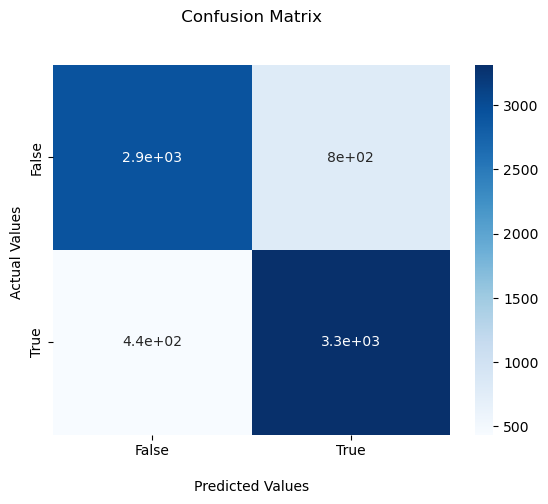

In [42]:
plot_cf(confusion_matrix(y_test,y_pred1))

In [44]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      3720
           1       0.81      0.88      0.84      3750

    accuracy                           0.83      7470
   macro avg       0.84      0.83      0.83      7470
weighted avg       0.84      0.83      0.83      7470



### Confusion matrix and classification score for XGBoast

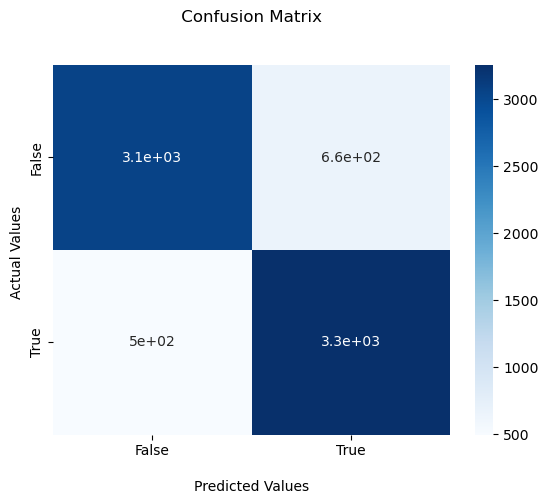

In [43]:
plot_cf(confusion_matrix(y_test,y_pred2))

In [45]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3720
           1       0.83      0.87      0.85      3750

    accuracy                           0.85      7470
   macro avg       0.85      0.85      0.85      7470
weighted avg       0.85      0.85      0.85      7470



## Conclusion


#### Insights :

- we notice precision for '0' recored in random forest was a percent higher but we see that '1' was higher in XGBoast
- For recall and f1-score we see that xgoast performs better than random forset
- The accuracy for XGBoast is 85% and for Random forest is 84%


 In conclusion we can see that **XGBoast performs better** although just by a few points.